In [51]:
pip install fastai numpy==1.26.4

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [52]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import shutil, random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import (
    DataBlock, ImageBlock, CategoryBlock, get_image_files,
    GrandparentSplitter, parent_label, Resize, aug_transforms,
    vision_learner, accuracy, ClassificationInterpretation, resnet34)
from fastai.torch_core import default_device
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time

In [53]:
# device selection
def set_device():
    if torch.cuda.is_available(): default_device('cuda'); print('使用CUDA加速')
    elif torch.backends.mps.is_available(): default_device('mps'); print('使用MPS加速')
    else: default_device('cpu'); print('使用CPU')
set_device()

使用CUDA加速


In [54]:
def split_dataset(src_base_path, dest_base_path, categories, train_ratio, valid_ratio, test_ratio):
    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios should add up to 1."
    
    # Remove existing destination directory if it exists
    if dest_base_path.exists():
        shutil.rmtree(dest_base_path)
    
    # Create destination directories
    for phase in ['train', 'valid', 'test']:
        for cat in categories:
            os.makedirs(dest_base_path/phase/cat, exist_ok=True)
    
    # Split and copy files for each category
    for cat in categories:
        files = list((Path(src_base_path)/cat).glob('*.*'))
        random.shuffle(files)
        n = len(files)
        
        # Calculate split indices
        train_end = int(n * train_ratio)
        valid_end = train_end + int(n * valid_ratio)
        
        # Split files into three sets
        train_files = files[:train_end]
        valid_files = files[train_end:valid_end]
        test_files = files[valid_end:]
        
        # Copy files to respective directories
        for f in train_files:
            shutil.copy(f, dest_base_path/'train'/cat/f.name)
        for f in valid_files:
            shutil.copy(f, dest_base_path/'valid'/cat/f.name)
        for f in test_files:
            shutil.copy(f, dest_base_path/'test'/cat/f.name)
        
        # Print statistics for each category
        print(f"\nCategory: {cat}")
        print(f"Total files: {n}")
        print(f"Train set: {len(train_files)} files")
        print(f"Valid set: {len(valid_files)} files")
        print(f"Test set: {len(test_files)} files")
        
        # Verify the splits
        assert len(train_files) + len(valid_files) + len(test_files) == n, \
            f"Split verification failed for category {cat}"
    
    # Print overall statistics
    print("\nOverall Dataset Statistics:")
    for phase in ['train', 'valid', 'test']:
        total_files = sum(len(list((dest_base_path/phase/cat).glob('*.*'))) 
                        for cat in categories)
        print(f"{phase.capitalize()} set: {total_files} files")

In [80]:
src_base_path = Path('dishes')
dest_base_path = Path('images')
cats = ['炒合菜', '葱爆羊肉', '地三鲜', '豆角炒肉', '腐竹烧肉', '锅包肉', '红烧带鱼', '红烧排骨', '虎皮青椒', '酱爆鸡丁', '酱爆茄子', '酱大骨', '酱烧豆腐', '椒盐平菇', '京酱肉丝', '韭菜炒豆干', '烤麸烧香菇', '腊肠炒荷兰豆', '辣炒鸡胗', '辣炒藕丁', '凉拌拉皮', '溜肉段', '梅菜扣肉', '芹菜炒香干', '青椒炒肥肠', '青蒜炒腊肉', '清炒西兰花', '肉末粉条', '四喜丸子', '蒜泥白肉', '蒜蓉粉丝娃娃菜', '蒜苔炒肉丝', '糖醋里脊', '五香熏鱼', '西葫芦炒鸡蛋', '香椿拌豆腐', '香辣虾', '洋葱炒猪肝', '油焖笋', '鱼香肉丝']
split_dataset(src_base_path, dest_base_path, cats, 0.6, 0.2, 0.2)


Category: 炒合菜
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 葱爆羊肉
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 地三鲜
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 豆角炒肉
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 腐竹烧肉
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 锅包肉
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 红烧带鱼
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 红烧排骨
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 虎皮青椒
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 酱爆鸡丁
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 酱爆茄子
Total files: 30
Train set: 18 files
Valid set: 6 files
Test set: 6 files

Category: 酱大骨
Total fil

In [84]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)
dls = dblock.dataloaders(dest_base_path, bs=64)

In [85]:
# 在创建dls后添加
print(f"训练集文件数量: {len(dls.train_ds)}")
print(f"验证集文件数量: {len(dls.valid_ds)}")

训练集文件数量: 720
验证集文件数量: 240


In [86]:
from PIL import Image
import os

def verify_images(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    img.verify()
            except Exception as e:
                print(f"损坏文件: {img_path} - {e}")
                
verify_images("images/train")
verify_images("images/valid")

In [87]:
print(f"训练集批次数量: {len(dls.train)}")
print(f"验证集批次数量: {len(dls.valid)}")

训练集批次数量: 11
验证集批次数量: 4


/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26757 (\N{CJK UNIFIED IDEOGRAPH-6885}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 33756 (\N{CJK UNIFIED IDEOGRAPH-83DC}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25187 (\N{CJK UNIFIED IDEOGRAPH-6263}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 32905 (\N{CJK UNIFIED IDEOGRAPH-8089}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26757 (\N{CJK UNIFIED IDEOGRAPH-6885}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **k

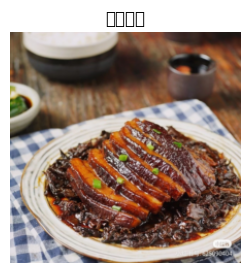

In [88]:
dls.show_batch(max_n=1)  # 显示最多9张图片

In [89]:
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=5, min_delta=0.01)
save_model_cb = SaveModelCallback(monitor='valid_loss', fname='best_model')

In [90]:
learn = vision_learner(dls, resnet34, metrics=accuracy, cbs=[early_stop_cb, save_model_cb])

In [91]:
# ... existing code ...

# 检查并修复图像文件
from PIL import Image
import os

def check_and_fix_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # 验证图像文件是否完整
            except Exception as e:
                print(f"文件 {file_path} 损坏或不支持，已删除: {e}")
                os.remove(file_path)  # 删除损坏或不支持的文件

# 检查并修复训练集和验证集中的图像文件
check_and_fix_images('images/train')
check_and_fix_images('images/valid')

# ... existing code ...
learn.fine_tune(100)

epoch,train_loss,valid_loss,accuracy,time
0,5.058167,3.195556,0.195833,00:03


Better model found at epoch 0 with valid_loss value: 3.195556163787842.


epoch,train_loss,valid_loss,accuracy,time
0,3.415628,2.606183,0.300000,00:03
1,2.961620,2.262684,0.395833,00:03
2,2.614793,1.957622,0.462500,00:03
3,2.268713,1.698408,0.541667,00:03
4,1.955295,1.496629,0.591667,00:03
5,1.670019,1.336948,0.616667,00:03
6,1.427527,1.209615,0.654167,00:03
7,1.220483,1.105801,0.691667,00:03
8,1.025489,1.029153,0.712500,00:03
9,0.866656,0.959257,0.716667,00:03


Better model found at epoch 0 with valid_loss value: 2.60618257522583.
Better model found at epoch 1 with valid_loss value: 2.2626841068267822.
Better model found at epoch 2 with valid_loss value: 1.9576220512390137.
Better model found at epoch 3 with valid_loss value: 1.6984082460403442.
Better model found at epoch 4 with valid_loss value: 1.4966285228729248.
Better model found at epoch 5 with valid_loss value: 1.3369483947753906.
Better model found at epoch 6 with valid_loss value: 1.2096154689788818.
Better model found at epoch 7 with valid_loss value: 1.105800986289978.
Better model found at epoch 8 with valid_loss value: 1.0291531085968018.
Better model found at epoch 9 with valid_loss value: 0.9592567682266235.
Better model found at epoch 10 with valid_loss value: 0.9136040806770325.
Better model found at epoch 11 with valid_loss value: 0.8748012781143188.
Better model found at epoch 12 with valid_loss value: 0.8366811871528625.
Better model found at epoch 13 with valid_loss valu

In [92]:
test_dl = dls.test_dl(get_image_files(dest_base_path/'test'), with_labels=True)
loss, acc = learn.validate(dl=test_dl)

Better model found at epoch 0 with valid_loss value: 0.75.


In [93]:
test_dl = dls.test_dl(get_image_files(dest_base_path/'test'), with_labels=True)
loss, acc = learn.validate(dl=test_dl)

Better model found at epoch 0 with valid_loss value: 0.75.


In [94]:
test_dl = dls.test_dl(get_image_files(dest_base_path/'test'), with_labels=True)
loss, acc = learn.validate(dl=test_dl)

Better model found at epoch 0 with valid_loss value: 0.75.


In [95]:
loss

0.7670190334320068

In [96]:
acc

0.75

/environment/miniconda3/lib/python3.11/site-packages/fastai/interpret.py:151: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/environment/miniconda3/lib/python3.11/site-packages/fastai/interpret.py:151: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/environment/miniconda3/lib/python3.11/site-packages/fastai/interpret.py:151: UserWarning: Glyph 29071 (\N{CJK UNIFIED IDEOGRAPH-718F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/environment/miniconda3/lib/python3.11/site-packages/fastai/interpret.py:151: UserWarning: Glyph 40060 (\N{CJK UNIFIED IDEOGRAPH-9C7C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/environment/miniconda3/lib/python3.11/site-packages/fastai/interpret.py:151: UserWarning: Glyph 20140 (\N{CJK UNIFIED IDEOGRAPH-4EAC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/environment/miniconda3/lib/python3.11/site-p

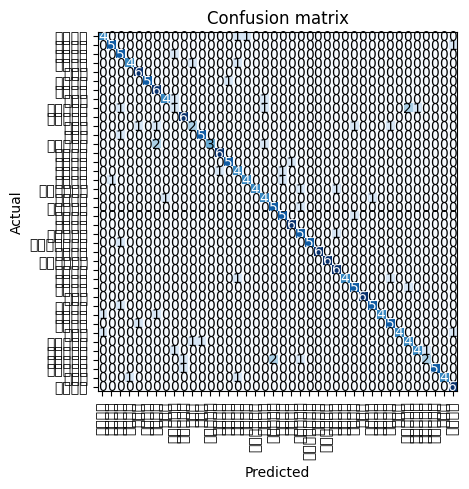

In [97]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [98]:
interp.print_classification_report()

              precision    recall  f1-score   support

        五香熏鱼       0.67      0.67      0.67         6
        京酱肉丝       0.83      0.83      0.83         6
        凉拌拉皮       0.56      0.83      0.67         6
        四喜丸子       0.80      0.67      0.73         6
         地三鲜       0.75      1.00      0.86         6
        梅菜扣肉       1.00      0.83      0.91         6
        椒盐平菇       0.60      1.00      0.75         6
         油焖笋       0.80      0.67      0.73         6
       洋葱炒猪肝       0.25      0.17      0.20         6
       清炒西兰花       0.75      1.00      0.86         6
         溜肉段       0.50      0.33      0.40         6
         炒合菜       0.83      0.83      0.83         6
       烤麸烧香菇       1.00      0.50      0.67         6
        糖醋里脊       0.86      1.00      0.92         6
        红烧带鱼       0.83      0.83      0.83         6
        红烧排骨       0.50      0.67      0.57         6
        肉末粉条       0.80      0.67      0.73         6
      腊肠炒荷兰豆       1.00    

/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 29071 (\N{CJK UNIFIED IDEOGRAPH-718F}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 40060 (\N{CJK UNIFIED IDEOGRAPH-9C7C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 37233 (\N{CJK UNIFIED IDEOGRAPH-9171}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/minicon

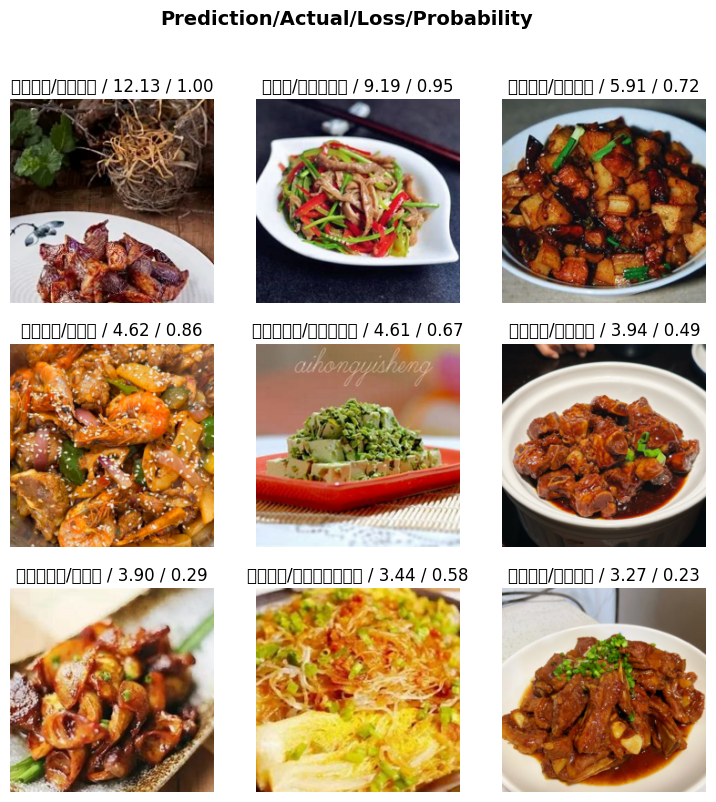

In [99]:
interp.plot_top_losses(9)

In [100]:
learn.export('1dish.pkl')